In [28]:
import argparse, uproot, matplotlib, pandas
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
from sklearn.preprocessing import MinMaxScaler

In [29]:
highMassPath = '/data/atlasfs02/a/users/whopkins/stopSignals/mc16_13TeV.436179.MGPy8EG_A14N23LO_TT_directTT_1300_1.e6985_a875_r10724_p3712_stop0L.root'
compressedPath = '/data/atlasfs02/a/users/whopkins/stopSignals/mc16_13TeV.436250.MGPy8EG_A14N23LO_TT_bWN_400_235_MadSpin_m1001L20.e7061_a875_r10724_p3736_stop0L.root'


In [30]:
highMassTree = uproot.open(highMassPath)['NominalFixed']
highMassData = highMassTree.arrays(['*'], outputtype=pandas.DataFrame)

compressedTree = uproot.open(compressedPath)['NominalFixed']
compressedData = compressedTree.arrays(['*'], outputtype=pandas.DataFrame)
    

In [31]:
fourVecVarNames = [varName for varName in list(compressedData.keys()) 
                   if ('pT' in varName or 'eta' in varName or 'phi' in varName or 'metsigST' in varName)
                  and ('sbv' not in varName and 'lightjet' not in varName 
                       and 'DNN' not in varName  and'track' not in varName
                      and 'dphi' not in varName and 'lep' not in varName.lower()
                      and 'pT_ll' not in varName and 'lastjet' not in varName
                      and 'fatjet' not in varName and 'seed' not in varName and 'fakejet' not in varName
                      and 'phi_met' not in varName and 'truth' not in varName and 'pTbV1' not in varName
                      and 'pTjV4' not in varName)]
print(fourVecVarNames)

['pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'pT_5jet', 'pT_6jet', 'eta_1jet', 'eta_2jet', 'eta_3jet', 'eta_4jet', 'eta_5jet', 'eta_6jet', 'phi_1jet', 'phi_2jet', 'phi_3jet', 'phi_4jet', 'phi_5jet', 'pT_1bjet', 'pT_2bjet', 'eta_1bjet', 'eta_2bjet', 'pT_1leadbtag', 'pT_2leadbtag', 'metsigST']


In [32]:
trainBranches = [
     'pT_1jet', 
#     'pT_2jet',
#     'pT_3jet',
#     'pT_4jet',
#     'm_1fatjet_kt12',
#     'm_2fatjet_kt12',
    
#    'eta_1jet', 
#     'eta_2jet',
#     'eta_3jet',
#     'eta_4jet',

#     'phi_1jet', 
#     'phi_2jet',
#     'phi_3jet',
#     'phi_4jet',
'metsigST', 
#     'meff', 
#     'dPhi_bjetMET',
#     'HT',
#     'mb23',
#  'dPhi_b1b23',
#  'asymm_b12b3',
#  'asymm_b2b3',
]

In [33]:
binnings = {
    'pT_1jet':[i*50 for i in range(30)],
    'pT_2jet':[i*20 for i in range(20)],
    'pT_3jet':[i*20 for i in range(20)],
    'pT_4jet':[i*20 for i in range(20)],
    'pT_5jet':[i*20 for i in range(20)],
    'm_1fatjet_kt12':[i*20 for i in range(20)],
    'm_2fatjet_kt12':[i*20 for i in range(20)],

    'eta_1jet':[-2.8+i*0.2 for i in range(29)],
    'eta_2jet':[-2.8+i*0.2 for i in range(29)],
    'eta_3jet':[-2.8+i*0.2 for i in range(29)],
    'eta_4jet':[-2.8+i*0.2 for i in range(29)],

    'phi_1jet':[-np.pi+i*(np.pi/16) for i in range(33)],
    'phi_2jet':[-np.pi+i*(np.pi/16) for i in range(33)],
    'phi_3jet':[-np.pi+i*(np.pi/16) for i in range(33)],
    'phi_4jet':[-np.pi+i*(np.pi/16) for i in range(33)],
    
    'pT_1bjet':[i*20 for i in range(20)],
    'pT_2bjet':[i*20 for i in range(20)],
    'pT_3bjet':[i*20 for i in range(20)],
    'pT_4bjet':[i*20 for i in range(20)],
    'eT_miss':[i*20 for i in range(20)],
    'metsigST':[i*2 for i in range(20)],
    'dR_lep1bjet':[i*0.4 for i in range(15)],
    'dR_lep2bjet':[i*0.4 for i in range(15)],

}
varLabels = {
        'pT_1lep':'$p_{\mathrm{T}}^{\\ell 1}$',  
        'pT_2lep':'$p_{\mathrm{T}}^{\\ell 2}$',  
        'pT_3lep':'$p_{\mathrm{T}}^{\\ell 3}$',  

    'pT_1jet':'$p_{\mathrm{T,1}}$',  
    'pT_2jet':'$p_{\mathrm{T,2}}$',  
  'pT_3jet':'$p_{\mathrm{T,3}}$',  
  'pT_4jet':'$p_{\mathrm{T,4}}$',  
  'pT_5jet':'$p_{\mathrm{T,5}}$',
        'eta_1jet':'$\eta_{\mathrm{T,1}}$',  
    'eta_2jet':'$\eta_{\mathrm{T,2}}$',  
    'eta_3jet':'$\eta_{\mathrm{T,3}}$',  
    'eta_4jet':'$\eta_{\mathrm{T,4}}$',  

        'phi_1jet':'$\phi_{\mathrm{T,1}}$',  
    'phi_2jet':'$\phi_{\mathrm{T,2}}$',  
    'phi_3jet':'$\phi_{\mathrm{T,3}}$',  
    'phi_4jet':'$\phi_{\mathrm{T,4}}$',  

  'pT_1bjet':'$p_{\mathrm{T,1}}^{b}$',  
  'pT_2bjet':'$p_{\mathrm{T,2}}^{b}$',  
  'pT_3bjet':'$p_{\mathrm{T,3}}^{b}$',  
  'pT_4bjet':'$p_{\mathrm{T,4}}^{b}$', 
    'eT_miss':'$E_{\mathrm{T}}^{\mathrm{miss}}$',
    'metsigST':'$\mathcal{S}$',
    'dR_lep1bjet':'$\Delta R(\ell 1,b)$',
    'dR_lep2bjet':'$\Delta R(\ell 2,b)$',
    'm_1fatjet_kt12':'m_1fatjet_kt12',
    'm_2fatjet_kt12':'m_2fatjet_kt12',
}
units = {
    'pT':'GeV',
    'eT_miss':'GeV',
}

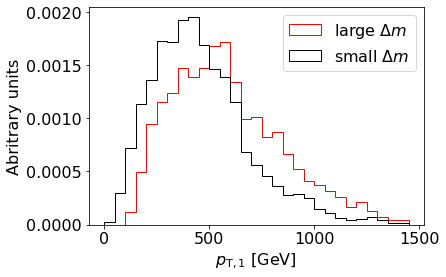

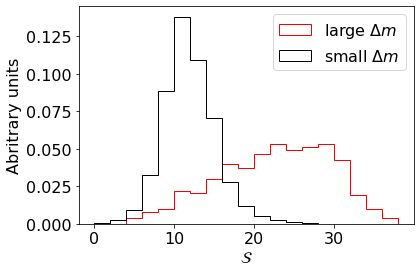

In [48]:
plt.close('all')

for varName in trainBranches:
    fig, ax = plt.subplots()
    plt.hist(highMassData[varName], bins=binnings[varName], histtype='step', density=True, color="red", label="large $\Delta m$")
    plt.hist(compressedData[varName], bins=binnings[varName], histtype='step', density=True, color='black', label="small $\Delta m$")
    ax.set_ylabel('Abritrary units')
    axUnit = ''
    for searchStr in units:
        if searchStr in varName:
            axUnit = ' ['+units[searchStr]+']'
            break;
    ax.set_xlabel(varLabels[varName]+axUnit)
    ax.legend()
    plt.savefig(f"{varName}.svg",bbox_inches='tight')
    plt.savefig(f"{varName}.pdf",bbox_inches='tight')



In [35]:
# Enough of all that noise, let's play start playing with clustering

In [36]:
import pandas as pd
trainData = pd.concat((highMassData[trainBranches], compressedData[trainBranches]))
#trainData = highMassData[trainBranches]

In [37]:
scaledData = trainData.copy(deep=True)
for column in trainBranches:
    scaler = MinMaxScaler()
    scaledData[[column]] = scaler.fit_transform(trainData[[column]])

clusteringData = scaledData
minX = 0
maxX = 1
minY = 0
maxY = 1

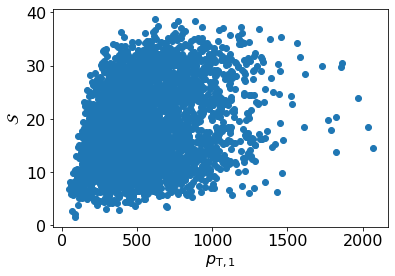

In [38]:
fig, ax = plt.subplots()
plt.scatter(trainData[trainBranches[0]], trainData[trainBranches[1]])
ax.set_xlabel(varLabels['pT_1jet'])
ax.set_ylabel(varLabels['metsigST'])
plt.savefig("scatter.svg",bbox_inches='tight')


In [39]:
from sklearn.cluster import KMeans



In [40]:
from sklearn.metrics import pairwise_distances

def compute_inertia(a, X):
    W = [np.mean(pairwise_distances(X[a == c, :])) for c in np.unique(a)]
    return np.mean(W)

def compute_gap(clustering, data, k_max=5, n_references=5):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(reference)
            local_inertia.append(compute_inertia(assignments, reference))
        reference_inertia.append(np.mean(local_inertia))
    
    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(data)
        ondata_inertia.append(compute_inertia(assignments, data))
        
    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

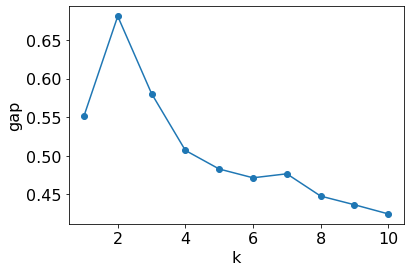

In [41]:
k_max = 10
gap, reference_inertia, ondata_inertia = compute_gap(KMeans(), clusteringData[trainBranches].to_numpy(), k_max)
plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')
plt.savefig("gap.svg",bbox_inches='tight')


In [42]:
## Now for lets select a number of clusters and have a look at the different cluster centroids

(4044,)


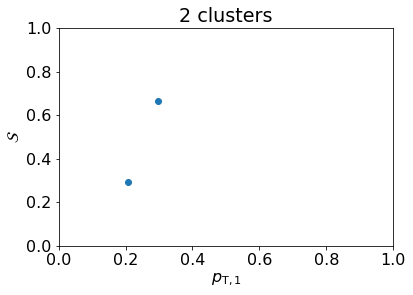

In [43]:
bestNClus = 2
fig, ax = plt.subplots()
Kmean = KMeans(n_clusters=bestNClus)
Kmean.fit(clusteringData[trainBranches])
centroids = Kmean.cluster_centers_
clusLabels = Kmean.labels_
plt.scatter(centroids[:,0], centroids[:,1])
ax.set_xlabel(varLabels['pT_1jet'])
ax.set_ylabel(varLabels['metsigST'])
ax.set_xlim([0,maxX])
ax.set_ylim([0,maxY])
ax.set_title(f'{bestNClus} clusters')
print(clusLabels.shape)

for clusI in range(bestNClus):
    fig, ax = plt.subplots()
    clusData = clusteringData[trainBranches][clusLabels==clusI]
    plt.scatter(clusData['pT_1jet'], clusData['metsigST'])
    ax.set_xlabel(varLabels['pT_1jet'])
    ax.set_ylabel(varLabels['metsigST'])
    ax.set_xlim([0,maxX])
    ax.set_ylim([0,maxY])
    ax.set_title(f'Cluster {clusI}')


In [44]:
## 1D histograms

0.37190900098911966
0.6280909990108803
0.37190900098911966
0.6280909990108803


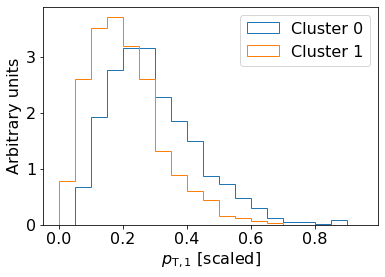

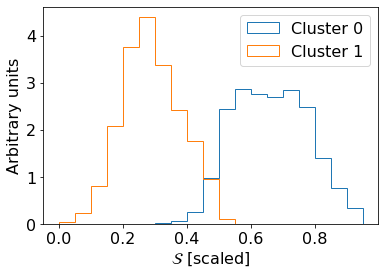

In [49]:
minFracOfTotal = 0.1
for varName in trainBranches:
    fig, ax = plt.subplots()
    for clusI in range(bestNClus):
        clusData = clusteringData[trainBranches][clusLabels==clusI]
        # Don't bother with clusters that are poorly represented ()
        if clusData.shape[0]/clusteringData[trainBranches].shape[0] < minFracOfTotal:
            continue
        print(clusData.shape[0]/clusteringData[trainBranches].shape[0])
        plt.hist(clusData[varName], bins=[0.05*i for i in range(20)], histtype='step', density=True, label=f"Cluster {clusI}")
        ax.set_xlabel(varLabels[varName]+' [scaled]')
        ax.set_ylabel('Arbitrary units')
        ax.legend()
        plt.savefig(f"{varName}_postclustering.svg",bbox_inches='tight')
        plt.savefig(f"{varName}_postclustering.pdf",bbox_inches='tight')



In [46]:
from sklearn.cluster import OPTICS
clust = OPTICS(min_cluster_size=0.015)
clust.fit(clusteringData[trainBranches])
labels = clust.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
for label in (set(labels)):
    print(f'Number of samples with {label} is {list(labels).count(label)}')

space = np.arange(clusteringData[trainBranches].shape[0])
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]


Estimated number of clusters: 2
Estimated number of noise points: 3917
Number of samples with 0 is 61
Number of samples with 1 is 66
Number of samples with -1 is 3917


In [47]:
fig, ax1 = plt.subplots()

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

Text(0.5, 1.0, 'Reachability Plot')